<img src="http://www.lineagelogistics.com/themes/custom/particle/dist/assets/lineage_logo.svg" alt="Lineage" width="400" align="left">

# Overview 

## Objective

## Guiding Questions:
1. What time period should we pick so that we have enough meaningful data to predict on?
2. What kind of distribution does the Ontario-Phoenix lane data have? Is it normal? If not, should we transform it?
3.  Are there any outliers that we can detect to improve our future prediction models? How does the data look like after outlier removal?
4. Is the data autocorrelated? If so, what lags have the highest correlation?

## Key findings 

1. Time period of collected data 2021-01-01 to 2022-05-31
2. Positive correlation of 0.15 between raw values of Ont-Phonenix and Pac-Mountain time-series.
3. Very strong positive correlation of 0.67 between 7-day averages of Ont-Phoenix and Pac-Mountain time-series.
4. Specific weekdays, months, holidays, division to division averages may be used as predictors for the future forecasting model.
5. High positive correlation between DAT contract rates and Payable Spot rates for Ont-Phoenix.



 


## Imports and setup

In [ ]:
# must go first
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Reloads functions each t ime so you can edit a script 
# and not need to restart the kernel
%load_ext autoreload
%autoreload 2

import sys
import os
import datetime
from datetime import datetime
from time import time
import datetime as dt

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
import numpy as np
from scipy import stats


# QQ Plot

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

sns.set()
sns.set_context('poster', font_scale=1.3)
sns.set_style("white")

import warnings
warnings.filterwarnings('ignore')

# basic wrangling
import numpy as np
import yaml
import json
import re
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

# eda tools
import pivottablejs
import missingno as msno
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Update matplotlib defaults to something nicer
mpl_update = {
    'font.size': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': [12.0, 8.0],
    'axes.labelsize': 20,
    'axes.labelcolor': '#677385',
    'axes.titlesize': 20,
    'lines.color': '#0055A7',
    'lines.linewidth': 3,
    'text.color': '#677385',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Tahoma'
}
mpl.rcParams.update(mpl_update)

ModuleNotFoundError: ignored

In [ ]:
# Create helper functions for specifying paths and appending
# directories with relevant python source code.
# This is a lot at the top of your notebook but if you get the jupyter
# extension for collapsing headings, you can always have this and the
# imports collapsed

root_dir = os.curdir
max_nest = 10  # arbitrary, 3 would probably suffice
nest = 0
while "src" not in os.listdir(root_dir) and nest < max_nest:
    # Look up the directory structure for a src directory
    root_dir = os.path.join(os.pardir, root_dir)
    nest += 1

# If you don't find the src directory, the root directory is this directory
root_dir = os.path.abspath(root_dir) if nest < max_nest else os.path.abspath(
    os.curdir)

# Get the source directory and append path to access
# python packages/scripts within directory
if "src" in os.listdir(root_dir):
    src_dir = os.path.join(root_dir, "src")
    sys.path.append(src_dir)

# If data or figures directory don't exist in project directory,
# they will be saved to this directory
data_dir = os.path.join(
    root_dir, "data") if "data" in os.listdir(root_dir) else os.curdir
external_data_dir = os.path.join(
    data_dir, "external") if "external" in os.listdir(data_dir) else os.curdir
figure_dir = os.path.join(
    root_dir,
    "figures") if "figures" in os.listdir(root_dir) else os.curdir
models_dir = os.path.join(
    root_dir,
    "models") if "models" in os.listdir(root_dir) else os.curdir

# Prepends the directory path for specifying paths to data or figures
# dataplus("data.csv") -> "/Users/cmawer/project/data/data.csv"
# figplus("cool.png") -> "/Users/cmawer/project/figures/cool.png"
dataplus = lambda x: os.path.join(data_dir, x)
dataextplus = lambda x: os.path.join(external_data_dir, x)
figplus = lambda x: os.path.join(figure_dir, x)
modelsplus = lambda x: os.path.join(models_dir, x)

# Prepends the date to a string (e.g. to save dated files)
# dateplus("cool-figure.png") -> "2018-12-05-cool-figure.png"
now = datetime.now().strftime("%Y-%m-%d")
dateplus = lambda x: "%s-%s" % (now, x)

In [ ]:
import sqlalchemy as sql
import pymysql

In [ ]:
# connect to data science RDS via SSH (delete cell if not needed) 
host = os.environ.get('TRANS_HOST') if os.environ.get('TRANS_HOST') is not None else '127.0.0.1'
port = os.environ.get('TRANS_PORT') if os.environ.get('TRANS_PORT') is not None else 3306
user = os.environ.get('TRANS_USER')
pw = os.environ.get('TRANS_PW')
db = 'trans'
driver = 'mysql+pymysql'

rds_engine = sql.create_engine('%s://%s:%s@%s:%s/%s' %
                                            (driver, user, pw, host, port, db))

%reload_ext sql_magic
%config SQL.conn_name = 'rds_engine'
%config SQL.output_result = False  # disable browser notifications
%config SQL.notify_result= True # Browser notification when query finishes

In [ ]:
# connect to Snowflake
from snowflake.sqlalchemy import URL
from snowflake.connector.pandas_tools import pd_writer

pw = os.environ.get('snowflake_pw')
user = os.environ.get('snowflake_user')
acct = os.environ.get('snowflake_acct')
role = os.environ.get('snowflake_role')
wh = os.environ.get('snowflake_warehouse')

engine = sql.create_engine(URL(
   account = acct,
   user = user,
   password = pw,
   database = 'DEV_SCIENCE',
   schema = 'TRANS',
   warehouse = wh,
   role=role,
))

%reload_ext sql_magic
%config SQL.conn_name = 'engine'
%config SQL.output_result = False  # disable browser notifications
%config SQL.notify_result= True # Browser notification when query finishes

In [ ]:
# To convert to html with collapsible headings and table of contents
# change filename, uncomment, and run cell

# filename = "template.ipynb"
# ! jupyter nbconvert --to html_ch {filename} --template toc2

# Notebook Parameters

In [ ]:

kma_1='Ontario Mkt'
kma_2='Phoenix Mkt'
min_distance=250
max_rpm=10
rolling_window=7
div_1='Pacific'
div_2='Mountain'

# Data

- **Raw file/table name:** `trans.rates`
- **Description of data:** Features generate to describe rates over time, the origin and destination regions of the freights, transportation mode, lane types, etc
- **Date range covered by data:** `2021-01-01` to `2022-05-31`

Query via sql_magic. Add `-a` after `df` to make query asynchronous so you can run other cells while the query executes (e.g. `%%read_sql df -a`)

In [ ]:
%%read_sql df
SELECT r.*, oregion.division as division__origin, dregion.division as division__dest
FROM 
    TRANS.RATES r
 LEFT JOIN GEO.state_regions oregion
 ON r.origin_state=oregion.state_code
 LEFT JOIN GEO.state_regions dregion
 ON r.destination_state=dregion.state_code
 WHERE is_contract_rate=False
 AND equipment_type='Reefer'
 AND transportation_mode='TL'
 AND start_date BETWEEN '2021-01-01' AND '2022-05-31'

Query started at 04:21:21 PM PDT; Query executed in 0.08 m

In [ ]:
df.shape

(53831, 37)

In [ ]:
sum(df['is_contract_rate'])

0

# Ontario to Phoenix rate distribution

For this analysis we are choosing Ontario-Phoenix lane since it has the distances greater than 300 miles, lower CV which indicates more stability and 68% of time series completeness

In [ ]:
df['date'] = df['start_date'].dt.date


In [ ]:
df=df.loc[df['distance'] >= min_distance]
df=df.loc[df['rpm'] <max_rpm]


In [ ]:
df.shape

(28535, 38)

* 25,296 observations were removed

In [ ]:
df.rpm.describe()

count    28535.000000
mean         4.364927
std          1.820615
min          0.000000
25%          3.163059
50%          4.371311
75%          5.489478
max          9.998566
Name: rpm, dtype: float64

In [ ]:
lane = df[(df.origin_region==kma_1)&(df.destination_region==kma_2)]

In [ ]:
lane.head()

,rate_source,pull_date,start_date,end_date,equipment_type,transportation_mode,lane_type,origin_city,origin_state,origin_zip5,origin_zip3,origin_region,destination_city,destination_state,destination_zip5,destination_zip3,destination_region,distance,n_stops,fuel_charge,linehaul_rate,all_in_rate,rpm,rate_type,is_contract_rate,carrier_name,carrier_reference,is_carrier_incumbent,is_lane_incumbent,more_recent_exists,original_identifier,origin_region_code,destination_region_code,orig_rate_source,most_recent_procurement,division__origin,division__dest,date
8,Payable,2022-07-17 22:00:01.168984,2021-07-02 19:06:00,2021-07-03 13:51:00,Reefer,TL,address to address,MIRA LOMA,CA,91752,917,Ontario Mkt,PHOENIX,AZ,85043,850,Phoenix Mkt,322,1,112.70,2787.30,3385.00,8.656211,Linehaul,False,PRIDE TRANSPORT,PRQT,True,True,None,128159158,CA_ONT,AZ_PHO,BluJay,None,Pacific,Mountain,2021-07-02
972,Payable,2022-07-17 22:00:01.168984,2021-07-29 23:00:00,2021-07-30 13:00:00,Reefer,TL,address to address,CITY OF INDUSTRY,CA,91746,917,Ontario Mkt,PHOENIX,AZ,85009,850,Phoenix Mkt,352,1,126.72,1973.28,2334.00,5.605909,Linehaul,False,REFRIGERATED FOOD EXP RFX REFE,RFXI,True,True,None,128915124,CA_ONT,AZ_PHO,BluJay,None,Pacific,Mountain,2021-07-29
1877,Payable,2022-07-17 22:00:01.168984,2021-09-01 06:00:00,2021-09-01 13:20:00,Reefer,TL,address to address,CITY OF INDUSTRY,CA,91746,917,Ontario Mkt,PHOENIX,AZ,85009,850,Phoenix Mkt,352,1,126.72,2035.28,2396.00,5.782045,Linehaul,False,CONVOY INC,CVYI,True,True,None,130780840,CA_ONT,AZ_PHO,BluJay,None,Pacific,Mountain,2021-09-01
2677,Payable,2022-07-17 22:00:01.168984,2021-09-17 01:45:00,2021-09-17 13:45:00,Reefer,TL,address to address,CITY OF INDUSTRY,CA,91746,917,Ontario Mkt,PHOENIX,AZ,85009,850,Phoenix Mkt,352,1,130.24,2069.76,2434.00,5.880000,Linehaul,False,MIDAMERICA FREIGHT HANDLERS,MDMH,True,True,None,132044993,CA_ONT,AZ_PHO,BluJay,None,Pacific,Mountain,2021-09-17
3024,Payable,2022-07-17 22:00:01.168984,2021-10-13 00:50:00,2021-10-13 13:00:00,Reefer,TL,address to address,CITY OF INDUSTRY,CA,91746,917,Ontario Mkt,PHOENIX,AZ,85009,850,Phoenix Mkt,352,1,140.80,1919.76,2300.56,5.453864,Linehaul,False,MIDWEST REFRIGERATED TRANSPORT,MWRA,True,True,None,132533957,CA_ONT,AZ_PHO,BluJay,None,Pacific,Mountain,2021-10-13


In [ ]:
lane.shape

(779, 38)

In [ ]:
def create_timeseries(df,col, freq='D',method ='bfill',value=None):
    # create series of all dates between the min and max
    all_days = pd.date_range(df.date.min(), df.date.max(),freq=freq)
    # get one value for each date to create one time series
    df=df.groupby('date').agg(MEDIAN_RPM=(col,'median'))

    # join to impute zeros 
    df= df.reindex(all_days, fill_value=np.nan)
    
    # add column that denotes imputed values
    df.loc[df['MEDIAN_RPM'].isna(), 'was imputed']=1
    
    # On the customer column of our data, impute the missing values with the LOCF
    df['MEDIAN_RPM']=df['MEDIAN_RPM'].fillna(method=method, value=value)
    
    
    
    return df

In [ ]:
lane=create_timeseries(lane,'rpm',method=None,value=lane.rpm.median())

In [ ]:
lane.head()

,MEDIAN_RPM,was imputed
2021-01-04,5.113269,NaN
2021-01-05,1.942771,NaN
2021-01-06,5.483871,1.0
2021-01-07,5.031447,NaN
2021-01-08,5.483871,1.0


Text(0, 0.5, 'Frequency')

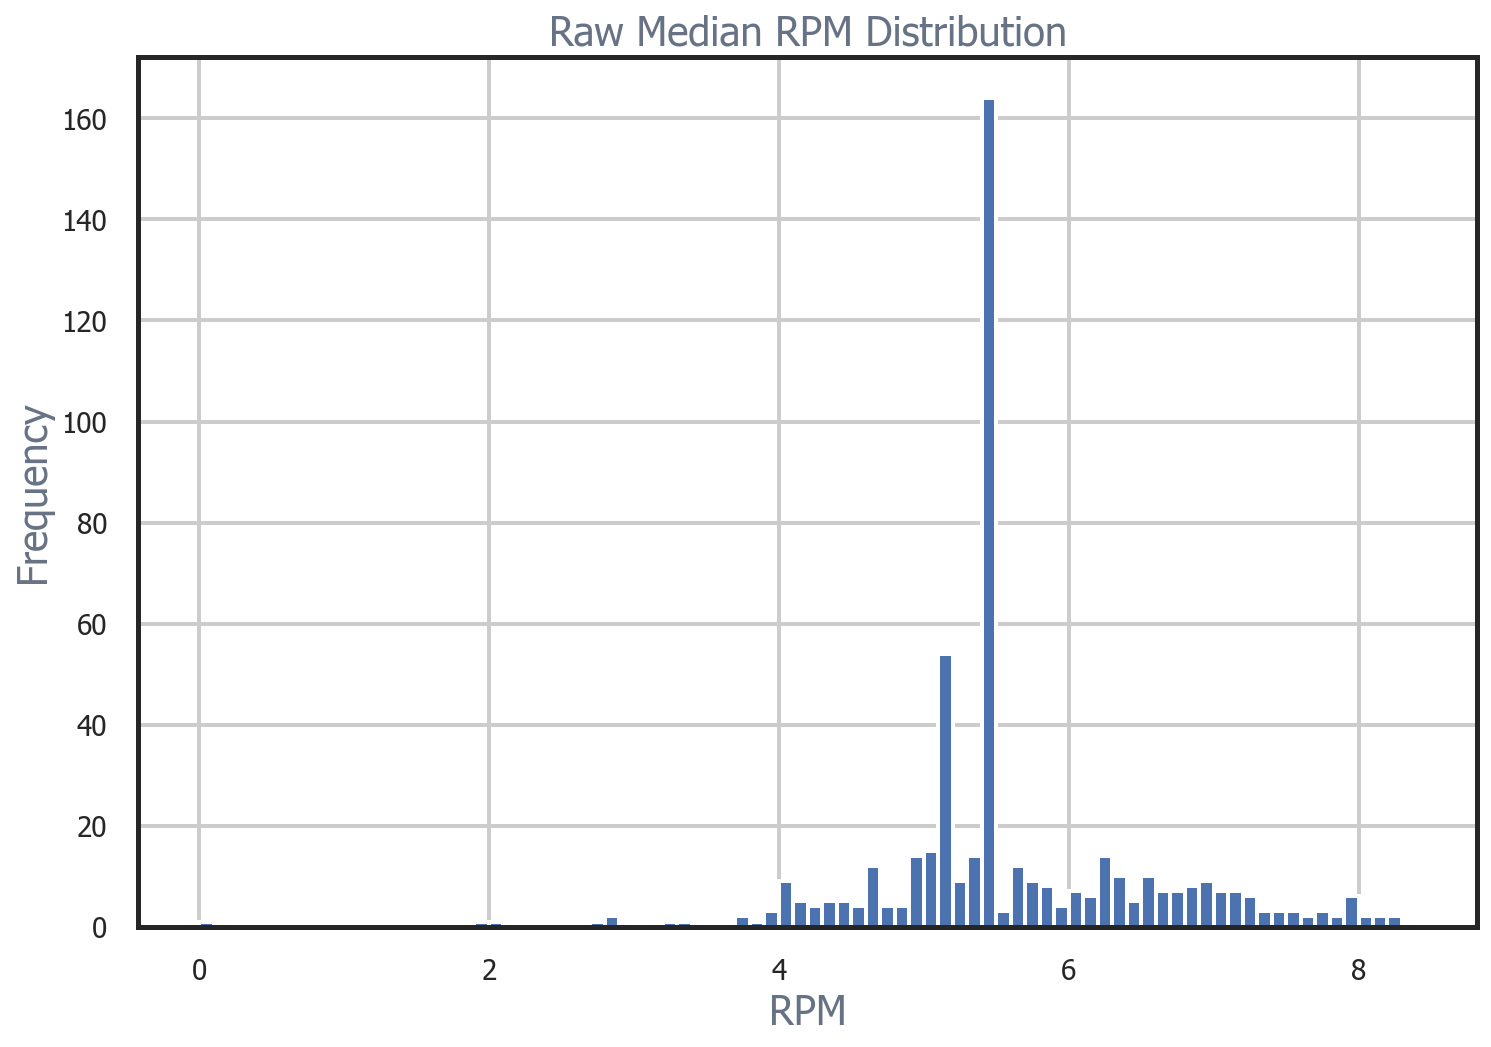

In [ ]:
lane['MEDIAN_RPM'].hist(bins=np.arange(0, 8.5, 0.1))
plt.title("Raw Median RPM Distribution")
plt.xlabel("RPM")
plt.ylabel("Frequency")

This plot shows the distribution of the linehaul rates for Ontario-Phoenix lane. The distribution is unimodal and roughly symmetrical

In [ ]:
# normality test
stat, p = shapiro(lane['MEDIAN_RPM'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.913, p=0.000
Sample does not look Gaussian (reject H0)


    Shapiro test indicates that the distribution is not normal but it looks pretty symmetric.Therefore, we proceed with several different tranformations: log, square root, and boxcox tranformations to see if the distribution becomes more normal.

## Log transformation

Text(0.5, 1.0, 'Log-Transformed Data')

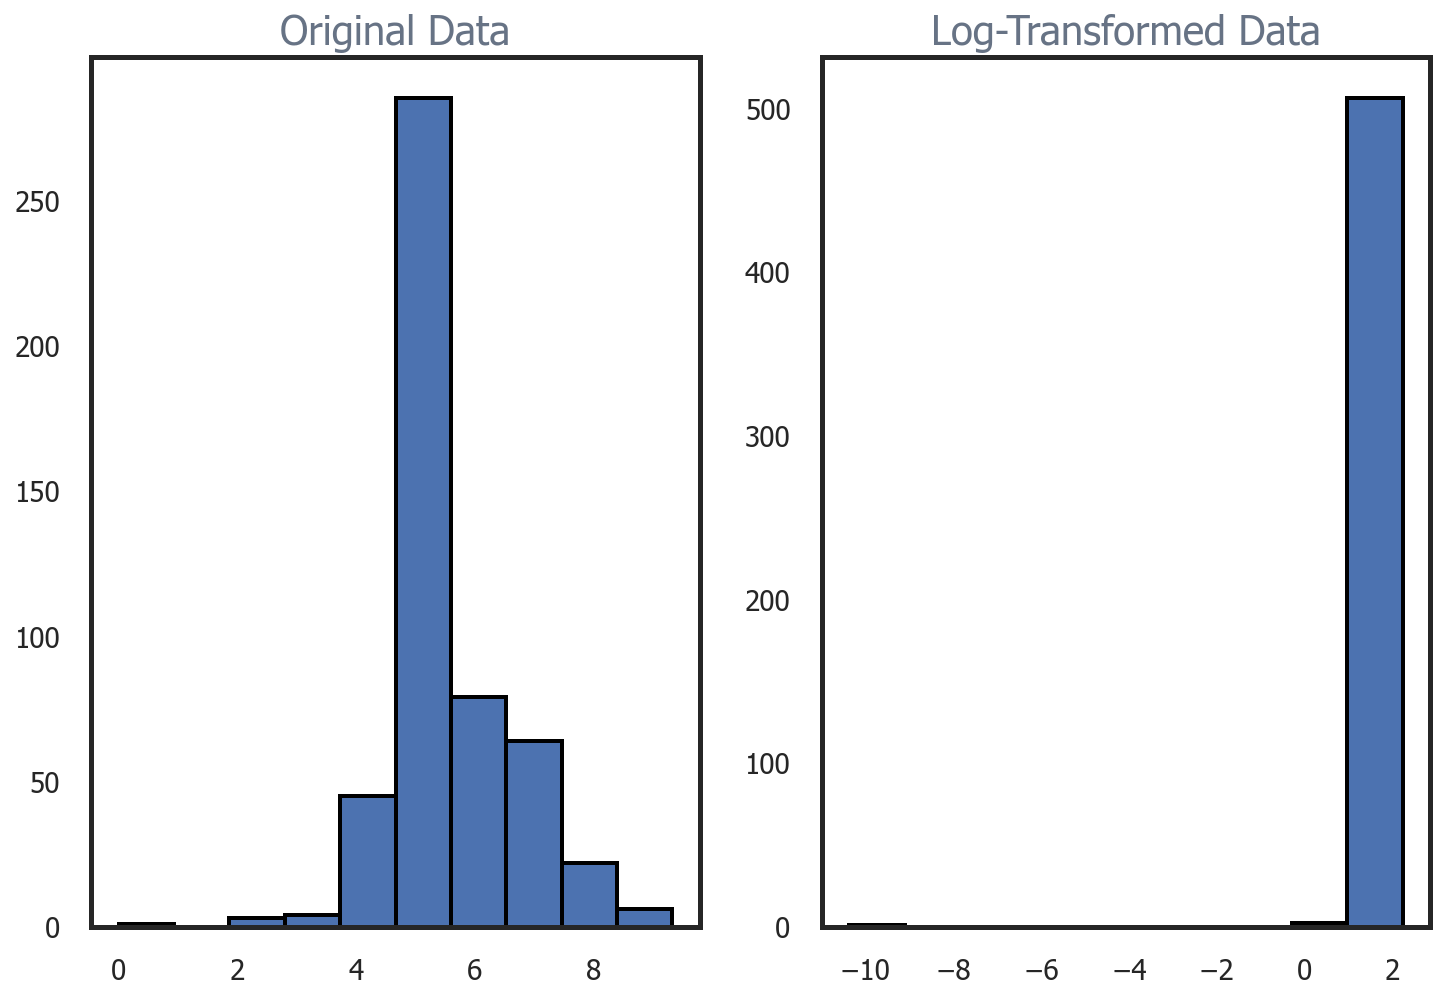

In [ ]:
#create beta distributed random variable with 200 values
data = lane['MEDIAN_RPM']

#create log-transformed data
rates_log = np.log(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(rates_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Log-Transformed Data')

Log transformation skewed all the data to the right, and made it left-tailed. The tranformed distribution is non-normal.

Text(0.5, 1.0, 'Square Root Transformed Data')

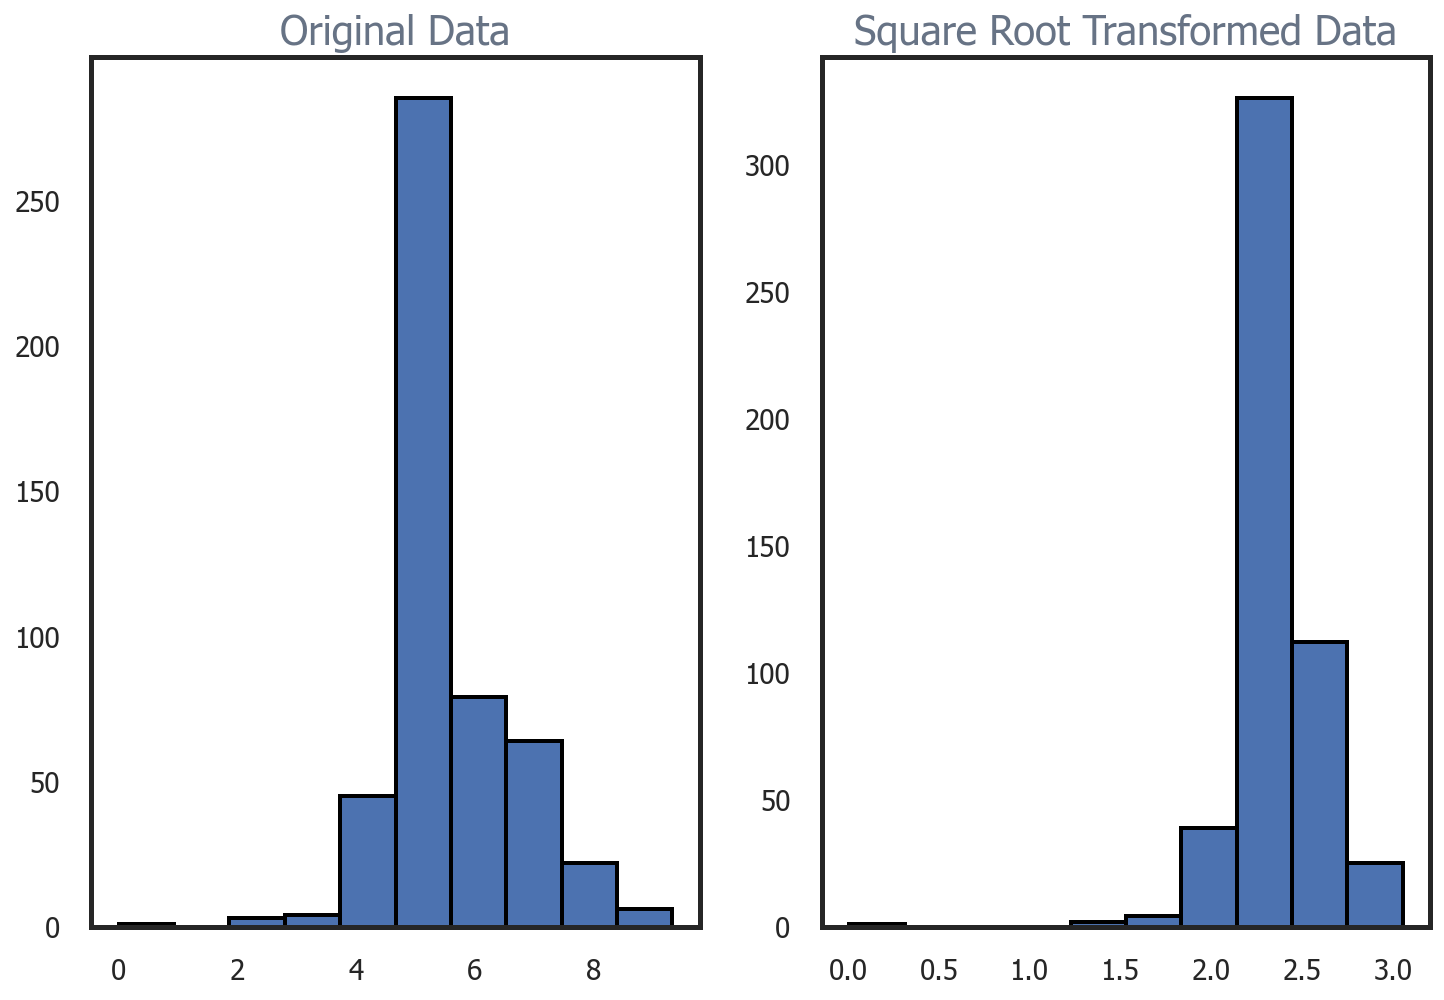

In [ ]:

#create beta distributed random variable with 200 values
data = lane['MEDIAN_RPM']

#create log-transformed data
rates_log = np.sqrt(data)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(data, edgecolor='black')
axs[1].hist(rates_log, edgecolor='black')

#add title to each histogram
axs[0].set_title('Original Data')
axs[1].set_title('Square Root Transformed Data')

Sqrt transformation skewed all the data to the right, and the graph has an outlier on the left side. The tranformed distribution is non-normal.

## BoxCox Transformation

Lambda value used for Transformation: 0.9883504949506011


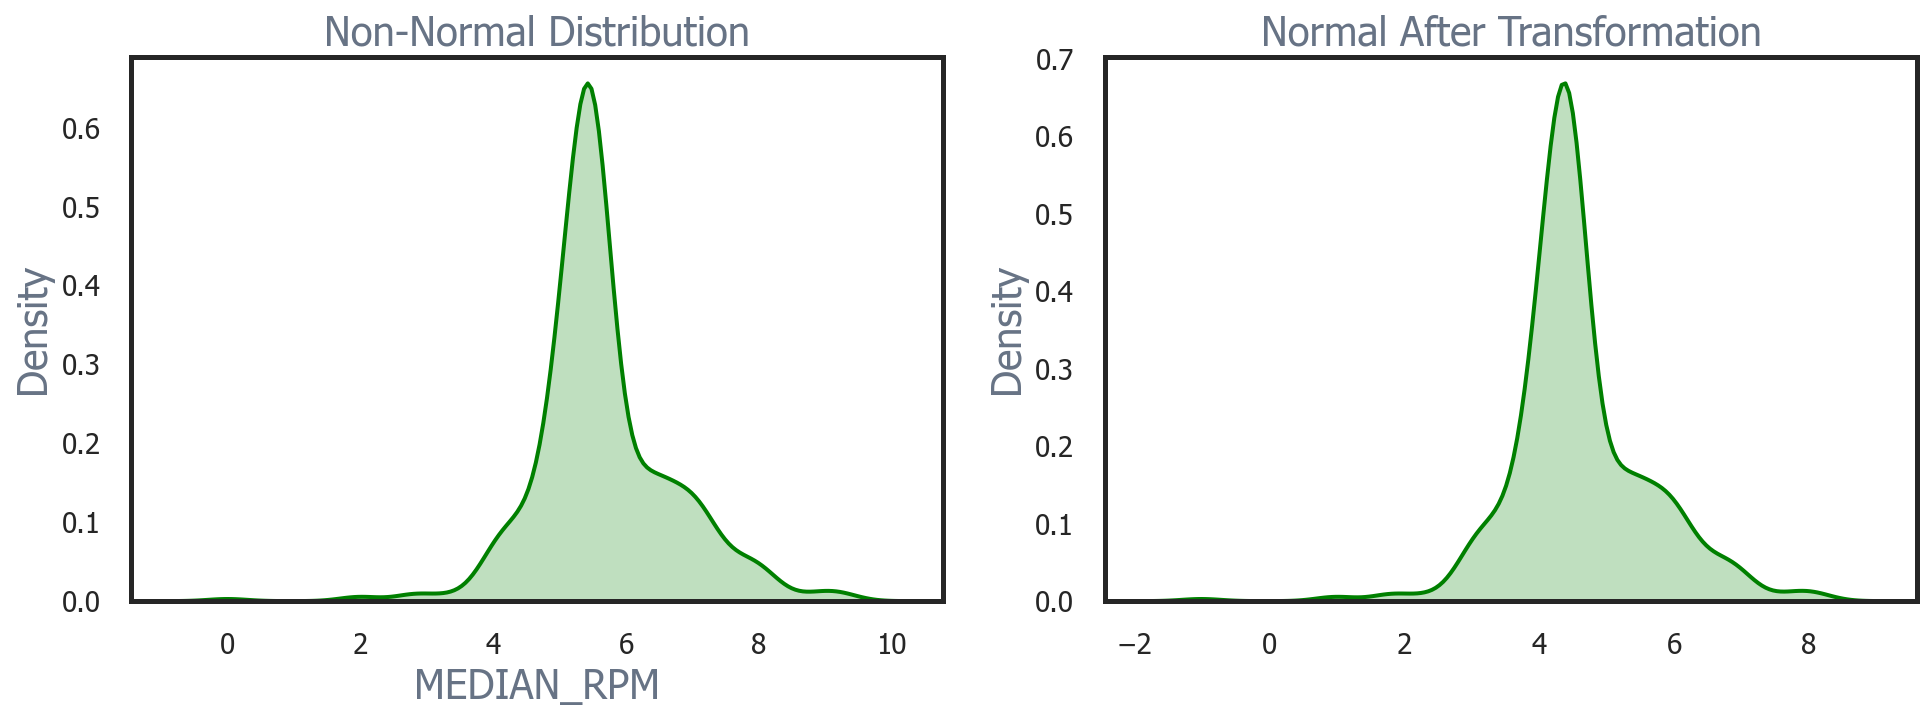

In [ ]:
# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(lane['MEDIAN_RPM'])
 
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(lane['MEDIAN_RPM'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0]).set(title='Non-Normal Distribution')

sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal After Transformation", color ="green", ax = ax[1]).set(title='Normal After Transformation')
 
 

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(16)
 
print(f"Lambda value used for Transformation: {fitted_lambda}")

The plot on the left shows the distribution of all rpm rates before transformation. The values are concentrated at ~6 the graph is unimodal. The plot on the right side shows the transformed rpm rates. The normal distribution peak is at ~6 now. However, BoxCox transformation did not change the shape of the data, nor the distribution. Thus, the tranformation was not useful in this case either. 

In [ ]:
(lane <= 0).sum().sum()

0

* Checking for negative and zero values of linehaul rates to proceed with the tranformation

In [ ]:
lane.shape

(509, 2)

## OUTLIER ANALYSIS

Text(0, 0.5, 'Rates')

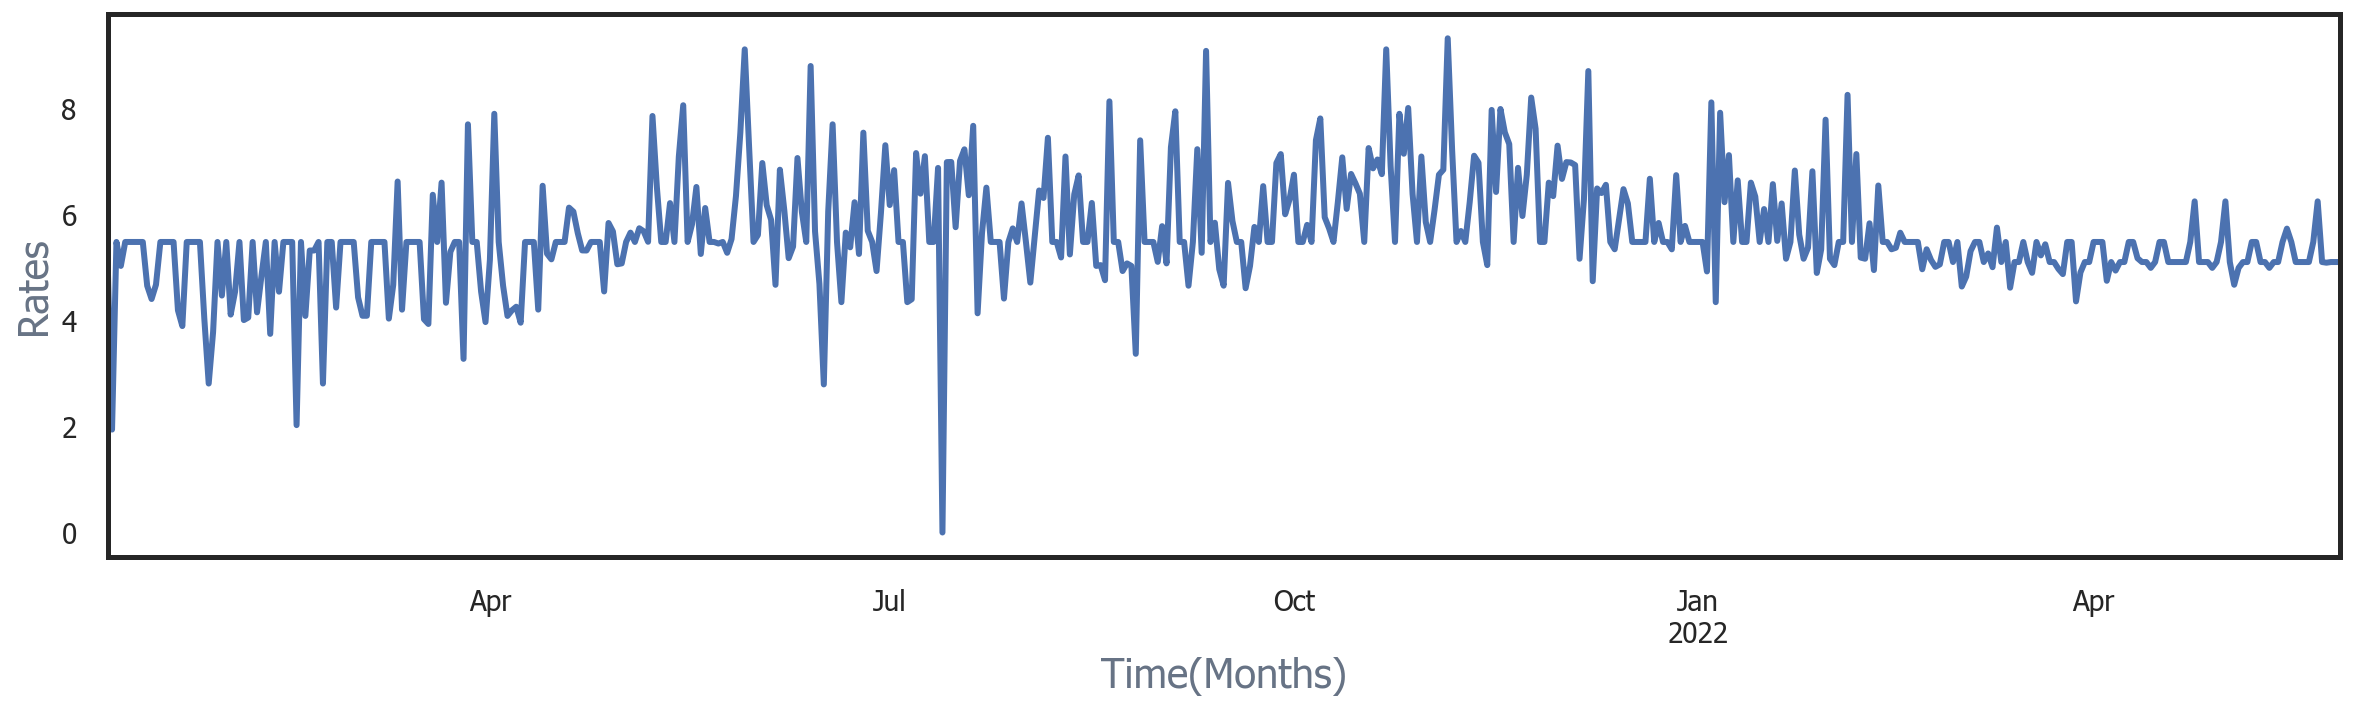

In [ ]:
fig,ax=plt.subplots(figsize=(20,5))
lane['MEDIAN_RPM'].plot(ax=ax)
plt.xlabel("Time(Months)")
plt.ylabel("Rates")

In [ ]:
def remove_outliers(df, rate_col,multiplier=1.5):
    
    Q1=df[rate_col].quantile(0.25)
    Q3=df[rate_col].quantile(0.75)
    IQR=Q3-Q1
    lower=Q1-multiplier*IQR
    upper=Q3+multiplier*IQR
  
    outliers_low=(df[rate_col]<lower)
    outliers_up=(df[rate_col]>upper)
    outliers=df[rate_col][(outliers_low | outliers_up)]
    df=pd.DataFrame(df[rate_col][~(outliers_low | outliers_up)])
    print('Removing %s values above:%s and below: %s' %(len(outliers),upper,lower))
    return df

In [ ]:
outliers_removed = remove_outliers(lane, 'MEDIAN_RPM',1.5)

Removing 32 values above:7.654030654030654 and below: 3.5757497757497756


Text(0, 0.5, 'Rates')

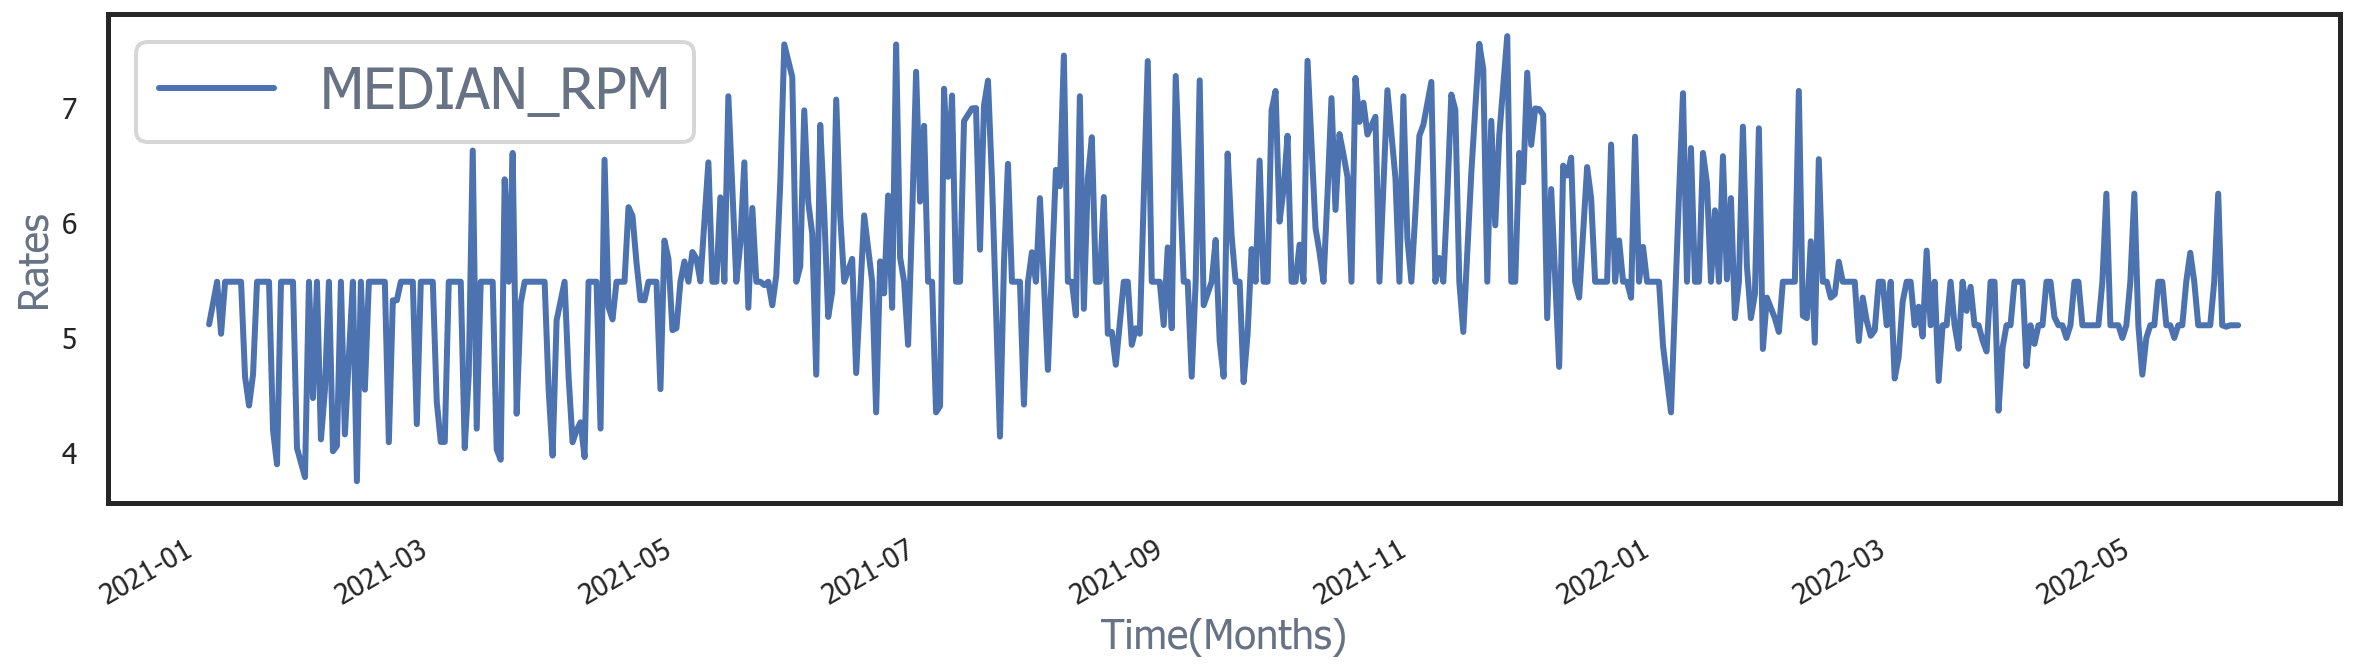

In [ ]:
fig,ax=plt.subplots(figsize=(20,5))
outliers_removed.plot(ax=ax)
plt.xlabel("Time(Months)")
plt.ylabel("Rates")

* Removing the outliers does not significantly change the graph. Therefore, different values for multiplier might yield different number of outliers and change the graph. Time-series looks non-stationary and volatile.



# Augmented Dickey-Fuller test

In [ ]:
series = lane['MEDIAN_RPM']
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.060303
p-value: 0.260774
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


* The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. There is no reason to reject the null hypothesis. So, the time series is in fact non-stationary. This is important for future prediction model selection as we might have to tranform the data into stationary by differencing, etc.

# Autocorrelation

Autoregression models make an assumption that the observations at previous time steps are useful to predict the value at the next time step.

    
    
We can calculate the correlation between the rates and rates at previous time steps and the autoregression model can weight the lagged variables with higher correlation more than the others.

Text(0, 0.5, 'PACF')

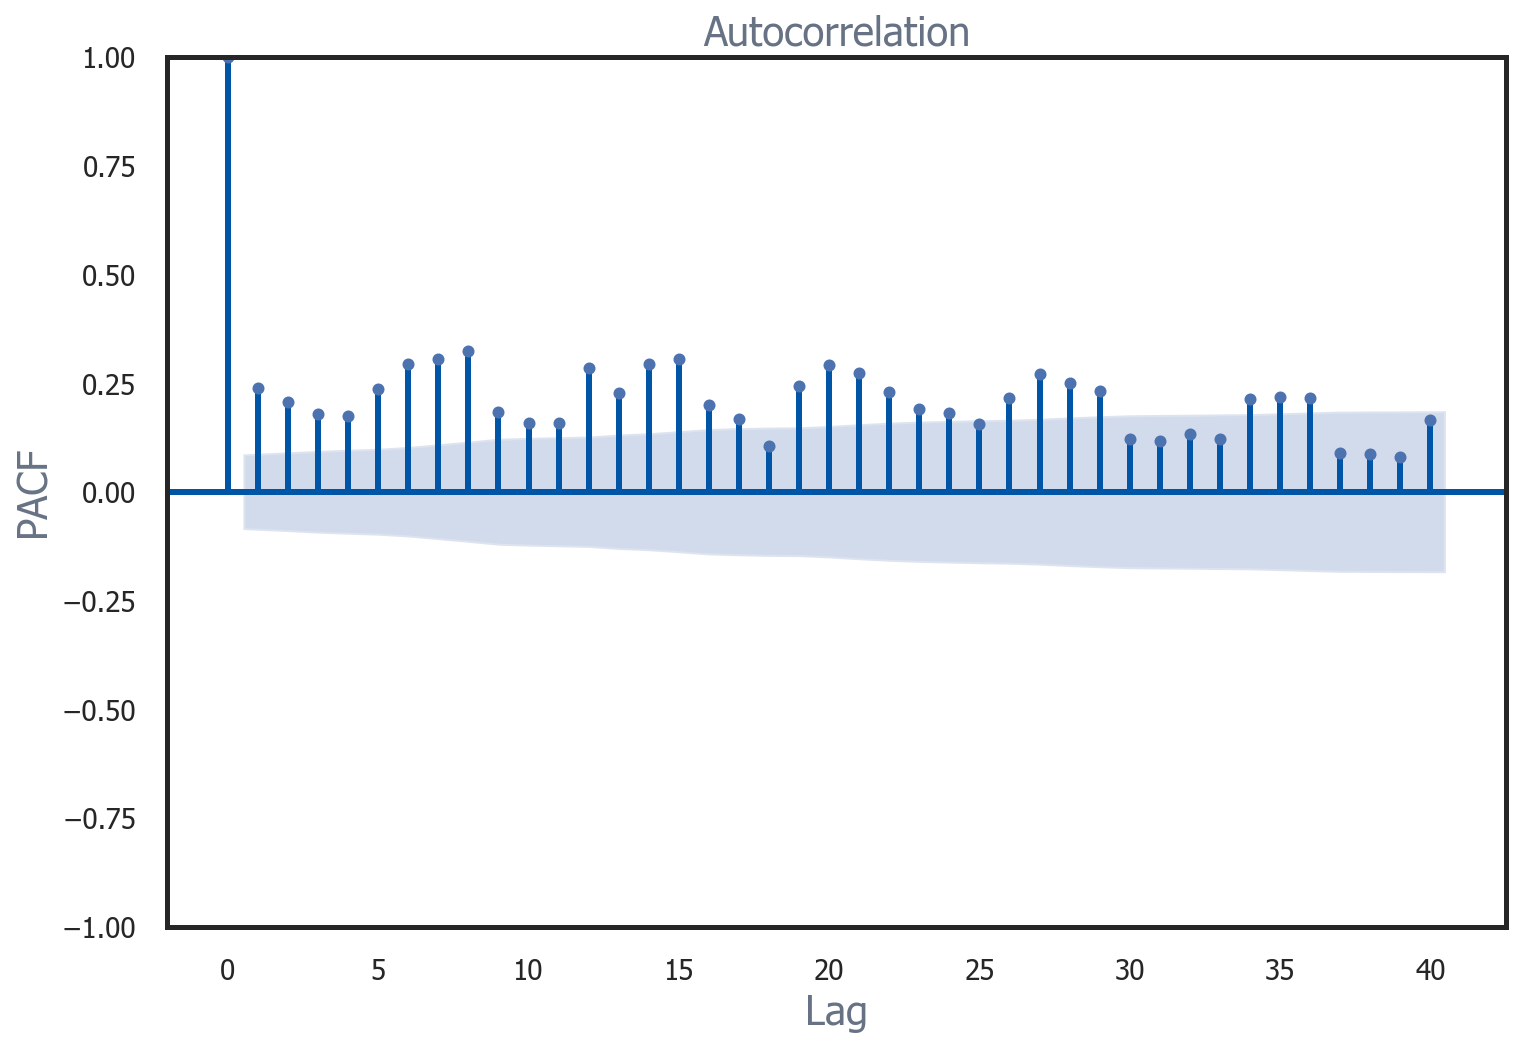

In [ ]:


data = lane['MEDIAN_RPM']
# plot the auto correlation and partial auto correlation

plot_acf(data,lags=40)

plt.xlabel("Lag")
plt.ylabel("PACF")



Significant positive correlation between all series (previous rates influence current ones). The coefficient is high at lag 9,16. The significance is lost after lag 18.


Correlation between rates from the previous day and one week prior have higher correlation than the other lags. There appears to be weekly seasonal patterns in the rates.

  

# Cross-correlations
Cross correlation is a way to measure the degree of similarity between a time series and a lagged version of another time series.
The time series of linehaul rates may be related to lags in other time series. We can potentially use these other time series to predict future rates.

## Pacific-Mountain without Ont-Phoenix rates!!

In [ ]:
pac_mount_small=df[(df.division__origin==div_1)&(df.division__dest==div_2)]

In [ ]:
pac_mount_small=pac_mount_small[~((pac_mount_small.origin_region==kma_1)&(pac_mount_small.destination_region==kma_2))]

In [ ]:
pac_mount_small.head()

,rate_source,pull_date,start_date,end_date,equipment_type,transportation_mode,lane_type,origin_city,origin_state,origin_zip5,origin_zip3,origin_region,destination_city,destination_state,destination_zip5,destination_zip3,destination_region,distance,n_stops,fuel_charge,linehaul_rate,all_in_rate,rpm,rate_type,is_contract_rate,carrier_name,carrier_reference,is_carrier_incumbent,is_lane_incumbent,more_recent_exists,original_identifier,origin_region_code,destination_region_code,orig_rate_source,most_recent_procurement,division__origin,division__dest,date
4,Payable,2022-07-17 22:00:01.168984,2021-06-30 17:06:00,2021-07-02 01:21:00,Reefer,TL,address to address,IRVINE,CA,92614,926,Los Angeles Mkt,SALT LAKE CITY,UT,84104,841,Salt Lake City Mkt,683,1,239.05,3660.95,3900.00,5.360102,Linehaul,False,PRIDE TRANSPORT,PRQT,True,True,None,128142593,CA_LAX,UT_SLC,BluJay,None,Pacific,Mountain,2021-06-30
5,Payable,2022-07-17 22:00:01.168984,2021-07-02 18:30:00,2021-07-06 13:36:00,Reefer,TL,address to address,IRVINE,CA,92614,926,Los Angeles Mkt,SALT LAKE CITY,UT,84104,841,Salt Lake City Mkt,683,1,239.05,3660.95,3900.00,5.360102,Linehaul,False,PRIDE TRANSPORT,PRQT,True,True,None,128144269,CA_LAX,UT_SLC,BluJay,None,Pacific,Mountain,2021-07-02
465,Payable,2022-07-17 22:00:01.168984,2021-07-09 21:00:00,2021-07-14 09:09:00,Reefer,TL,address to address,SOUTH GATE,CA,90280,902,Los Angeles Mkt,TREMONTON,UT,84337,843,Salt Lake City Mkt,759,1,273.24,3934.35,4207.59,5.183597,Linehaul,False,PRIDE TRANSPORT,PRQT,True,True,None,128515964,CA_LAX,UT_SLC,BluJay,None,Pacific,Mountain,2021-07-09
593,Payable,2022-07-17 22:00:01.168984,2021-07-09 22:14:00,2021-07-14 09:11:00,Reefer,TL,address to address,SOUTH GATE,CA,90280,902,Los Angeles Mkt,TREMONTON,UT,84337,843,Salt Lake City Mkt,759,1,273.24,3934.35,4207.59,5.183597,Linehaul,False,PRIDE TRANSPORT,PRQT,True,True,None,128522803,CA_LAX,UT_SLC,BluJay,None,Pacific,Mountain,2021-07-09
1106,Payable,2022-07-17 22:00:01.168984,2021-08-02 20:36:00,2021-08-04 00:21:00,Reefer,TL,address to address,BLOOMINGTON,CA,92316,923,Ontario Mkt,FARR WEST,UT,84404,844,Salt Lake City Mkt,681,1,245.16,3254.84,3645.00,4.779501,Linehaul,False,PRIDE TRANSPORT,PRQT,True,True,None,129271902,CA_ONT,UT_SLC,BluJay,None,Pacific,Mountain,2021-08-02


In [ ]:
pac_mount_small=create_timeseries(pac_mount_small,'rpm',method=None,value=pac_mount_small.rpm.median())

In [ ]:
pac_mount_small.head()

,MEDIAN_RPM,was imputed
2021-01-02,7.173913,NaN
2021-01-03,4.472425,1.0
2021-01-04,4.247150,NaN
2021-01-05,5.277778,NaN
2021-01-06,4.027912,NaN


In [ ]:
#pd.concat([df1, df2], axis=1)
df_correlate= pd.concat([pac_mount_small, lane],axis=1)
df_correlate.head()

,MEDIAN_RPM,was imputed,MEDIAN_RPM,was imputed
2021-01-02,7.173913,NaN,NaN,NaN
2021-01-03,4.472425,1.0,NaN,NaN
2021-01-04,4.247150,NaN,5.113269,NaN
2021-01-05,5.277778,NaN,1.942771,NaN
2021-01-06,4.027912,NaN,5.483871,1.0


In [ ]:
df_correlate.columns=['pac_mount_med_rates', 'was_imputed1','ont_phx_med_rates','was_imputed2']

In [ ]:
#correlation without imputed values
df_correlate_clean= df_correlate[(df_correlate.was_imputed1 != 1) & (df_correlate.was_imputed2 != 1)]

In [ ]:
df_correlate_clean.head()

,pac_mount_med_rates,was_imputed1,ont_phx_med_rates,was_imputed2
2021-01-02,7.173913,NaN,NaN,NaN
2021-01-04,4.247150,NaN,5.113269,NaN
2021-01-05,5.277778,NaN,1.942771,NaN
2021-01-07,4.012634,NaN,5.031447,NaN
2021-01-13,1.330532,NaN,4.656571,NaN


In [ ]:
df_correlate_clean=df_correlate_clean.drop(columns=['was_imputed1', 'was_imputed2'])

Pandas computed Pearson r: 0.153
Scipy computed Pearson r: 0.153 and p-value: 0.00746


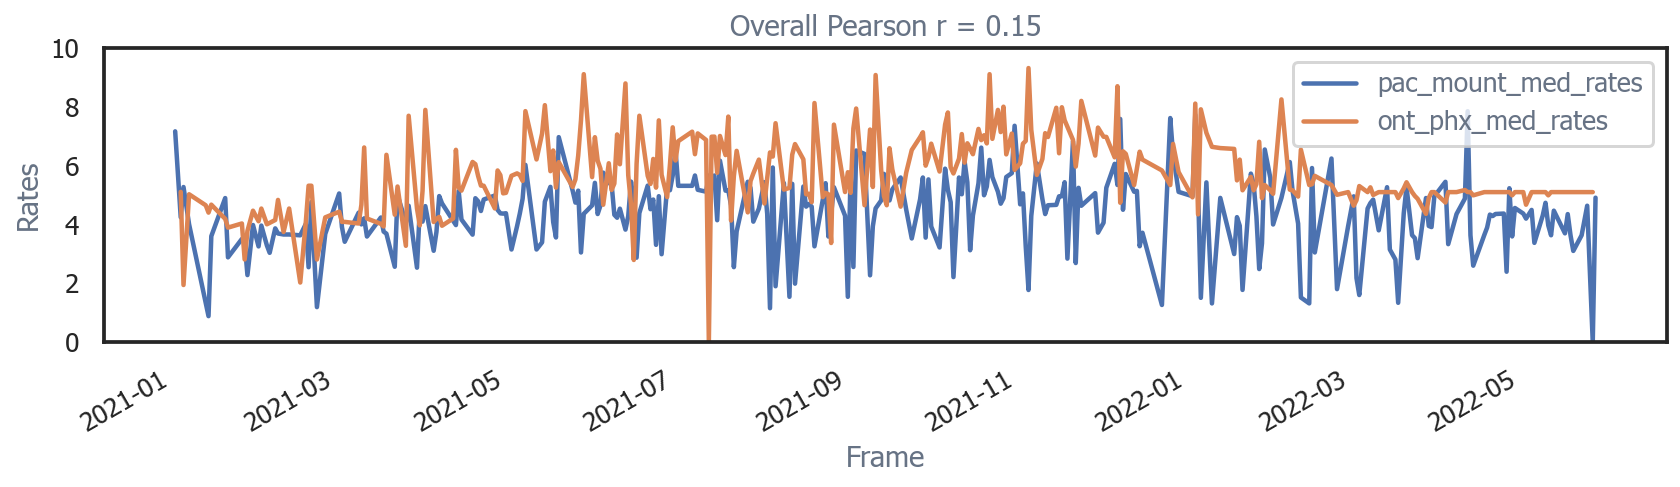

In [ ]:
#pearson corr

%matplotlib inline

import scipy.stats as stats
sns.set_context('talk',font_scale=.8)


overall_pearson_r = df_correlate_clean.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r:.3g}")

r, p = stats.pearsonr(df_correlate_clean.dropna()['pac_mount_med_rates'], df_correlate_clean.dropna()['ont_phx_med_rates'])
print(f"Scipy computed Pearson r: {r:.3g} and p-value: {p:.3g}")

f,ax=plt.subplots(figsize=(14,3))
df_correlate_clean.plot(ax=ax)

ax.set(xlabel='Frame',ylabel='Rates',title=f"Overall Pearson r = {overall_pearson_r:.2g}",ylim=(0,10));

* The pearson r of 0.15 indicates that the correlation between raw median values of Pacific-Mountan and Ont-Phx lanes is weak but positive. Therefore, we will look at correlation between the 7-day averaged values.

In [ ]:
#7 day moving average
SMA7=df_correlate_clean.rolling(rolling_window).mean()

Pandas computed Pearson r: 0.673
Scipy computed Pearson r: 0.673 and p-value: 6.13e-41


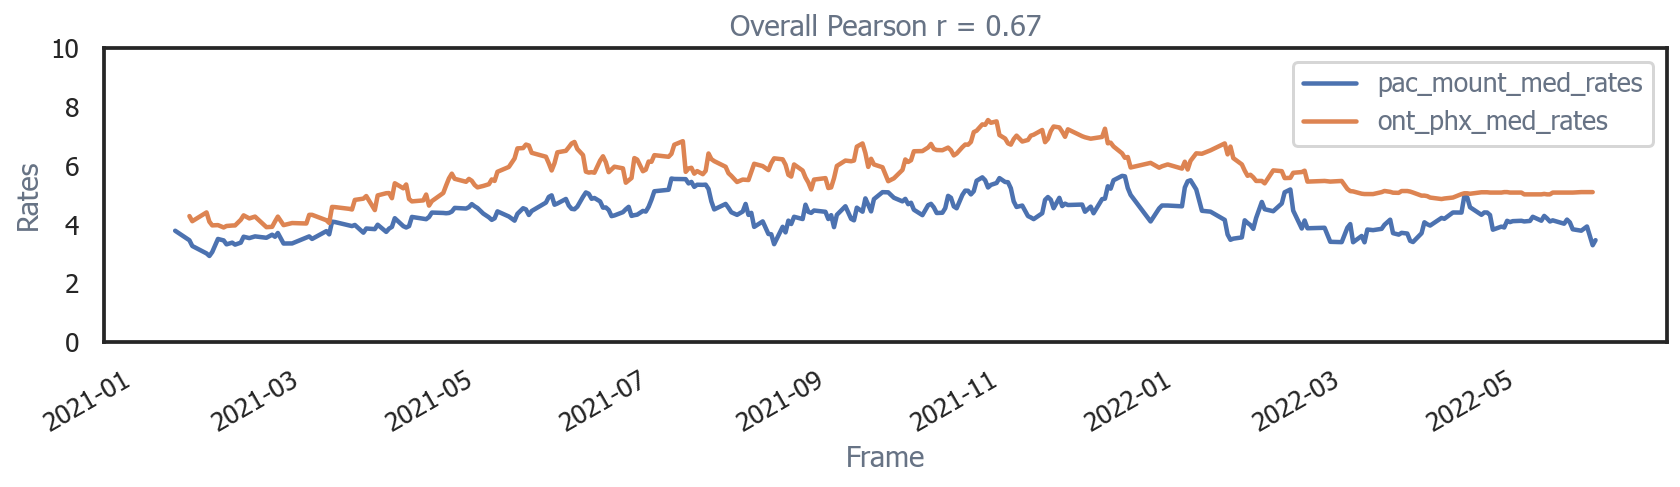

In [ ]:
#pearson corr

%matplotlib inline

import scipy.stats as stats
sns.set_context('talk',font_scale=.8)


overall_pearson_r = SMA7.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r:.3g}")

r, p = stats.pearsonr(SMA7.dropna()['pac_mount_med_rates'], SMA7.dropna()['ont_phx_med_rates'])
print(f"Scipy computed Pearson r: {r:.3g} and p-value: {p:.3g}")

f,ax=plt.subplots(figsize=(14,3))
SMA7.plot(ax=ax)

ax.set(xlabel='Frame',ylabel='Rates',title=f"Overall Pearson r = {overall_pearson_r:.2g}",ylim=(0,10));

* High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation. Therefore, Pearson value of 0.72 indicates strong correlation between Pacific-Mountain and Ontario-Phoenix rates. High correlation shows that we could potentially use the division of origin and destination to predict rates in case we are missing data for the actual KMA lane. This way we know that division to division lanes and KMA to KMA have similar trends.




In [ ]:
df_correlate_clean.head(20)

,pac_mount_med_rates,ont_phx_med_rates
2021-01-02,7.173913,NaN
2021-01-04,4.247150,5.113269
2021-01-05,5.277778,1.942771
2021-01-07,4.012634,5.031447
2021-01-13,1.330532,4.656571
2021-01-14,0.882730,4.407115
2021-01-15,3.604194,4.677419
2021-01-20,4.901961,4.193548
2021-01-21,2.884270,3.896104
2021-01-26,3.510101,4.037267


# Box Plot for weekday rates Ont-Phoenix without imputations

In [ ]:
lane= lane[(lane['was imputed'] != 1)]

In [ ]:
lane['weekday'] = lane.index.weekday

In [ ]:
lane.head()

,MEDIAN_RPM,was imputed,weekday
2021-01-04,5.113269,NaN,0
2021-01-05,1.942771,NaN,1
2021-01-07,5.031447,NaN,3
2021-01-13,4.656571,NaN,2
2021-01-14,4.407115,NaN,3


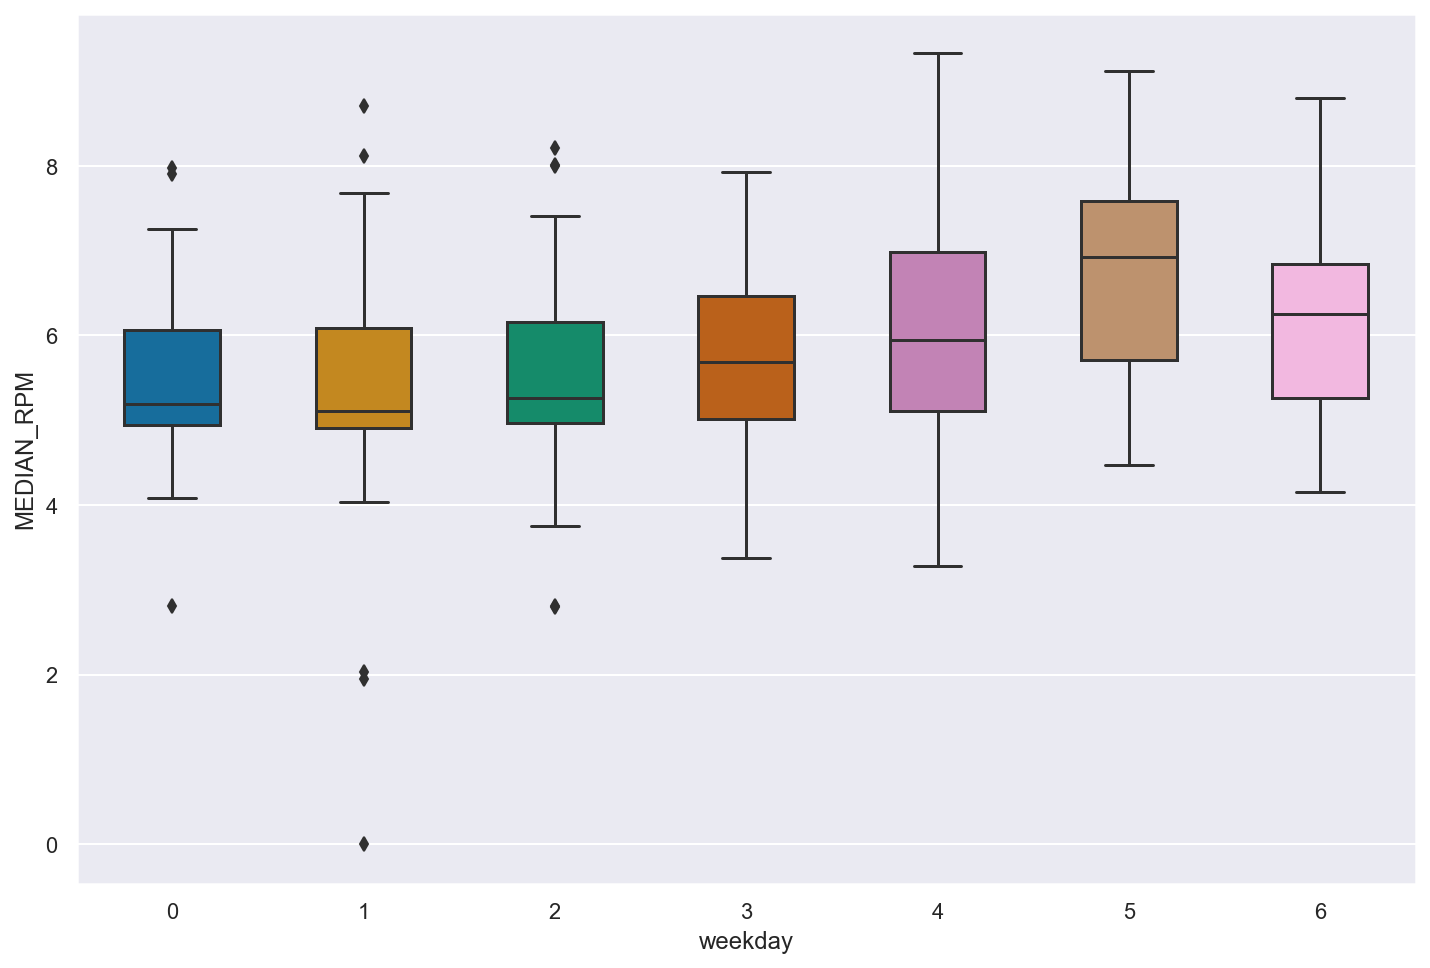

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
bplot=sns.boxplot(y='MEDIAN_RPM', x='weekday', data=lane, palette="colorblind",width=0.5)


* Rates get higher over the weekend with the highest on Saturdays (avg of $7)

# Boxplot of rates by month

In [ ]:
lane= lane[(lane['was imputed'] != 1)]

In [ ]:
lane['month'] = lane.index.month

In [ ]:
lane.head()

,MEDIAN_RPM,was imputed,weekday,month
2021-01-04,5.113269,NaN,0,1
2021-01-05,1.942771,NaN,1,1
2021-01-07,5.031447,NaN,3,1
2021-01-13,4.656571,NaN,2,1
2021-01-14,4.407115,NaN,3,1


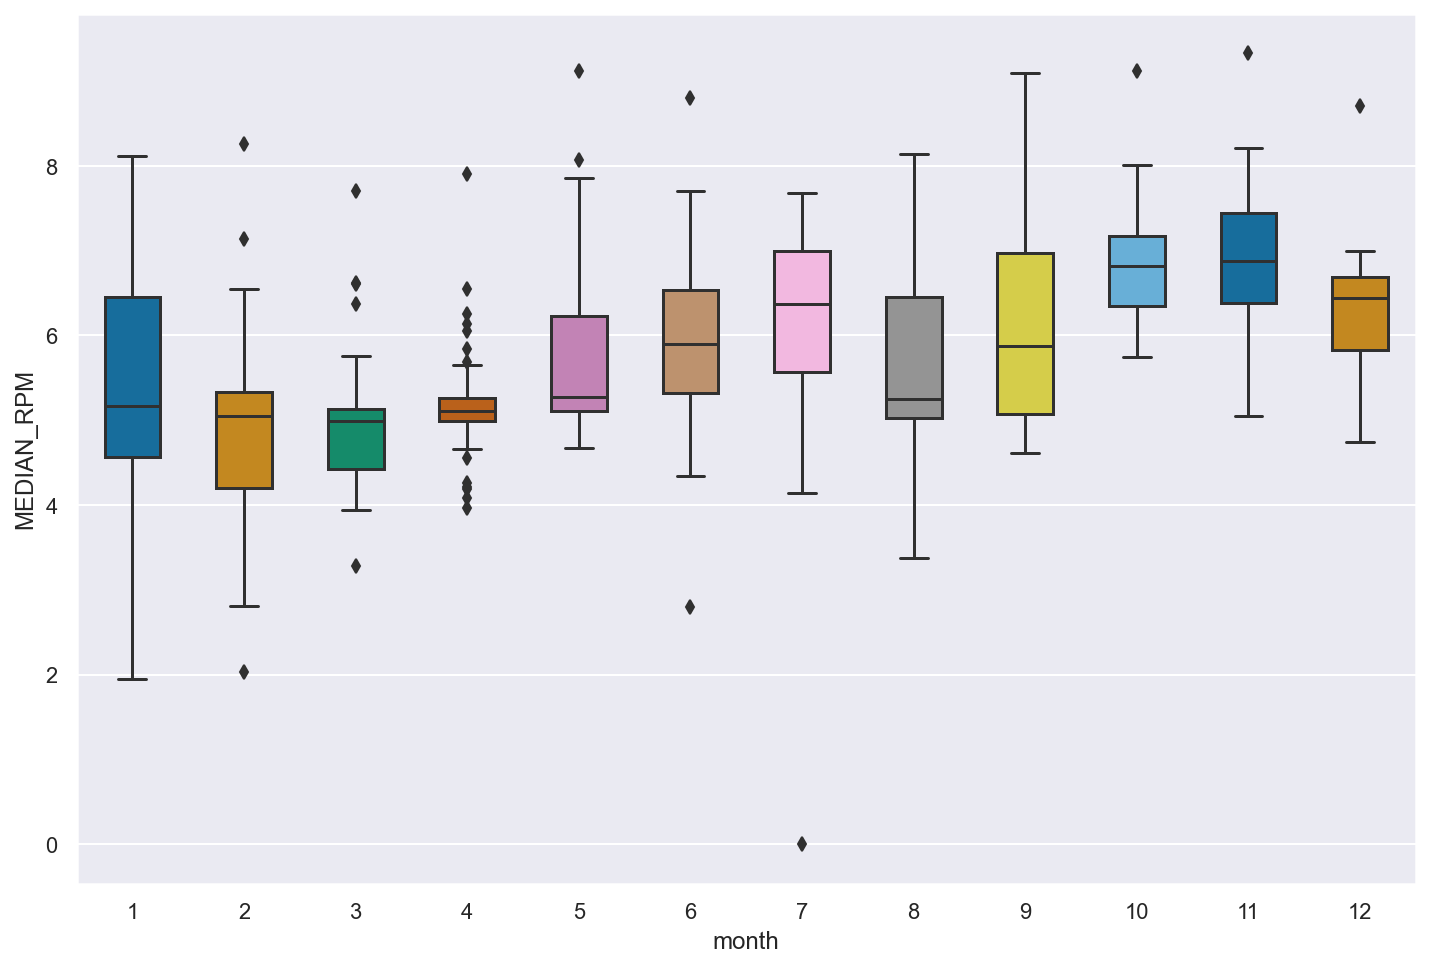

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
bplot=sns.boxplot(y='MEDIAN_RPM', x='month', data=lane, palette="colorblind",width=0.5)


* Rates get higher towards the end of the year

#  Boxplot of rates by holidays

In [ ]:
lane.reset_index(inplace=True)

In [ ]:
lane['index'].dt.date

0      2021-01-04
1      2021-01-05
2      2021-01-07
3      2021-01-13
4      2021-01-14
          ...    
344    2022-05-23
345    2022-05-24
346    2022-05-25
347    2022-05-26
348    2022-05-27
Name: index, Length: 349, dtype: object

In [ ]:

cal = calendar()
holidays = cal.holidays(start=lane['index'].min(), end=lane['index'].max())

lane['Holiday'] = lane['index'].isin(holidays)

In [ ]:
lane

,index,MEDIAN_RPM,was imputed,weekday,month,Holiday
0,2021-01-04,5.113269,NaN,0,1,False
1,2021-01-05,1.942771,NaN,1,1,False
2,2021-01-07,5.031447,NaN,3,1,False
3,2021-01-13,4.656571,NaN,2,1,False
4,2021-01-14,4.407115,NaN,3,1,False
...,...,...,...,...,...,...
344,2022-05-23,5.105105,NaN,0,5,False
345,2022-05-24,5.092553,NaN,1,5,False
346,2022-05-25,5.105105,NaN,2,5,False
347,2022-05-26,5.105105,NaN,3,5,False


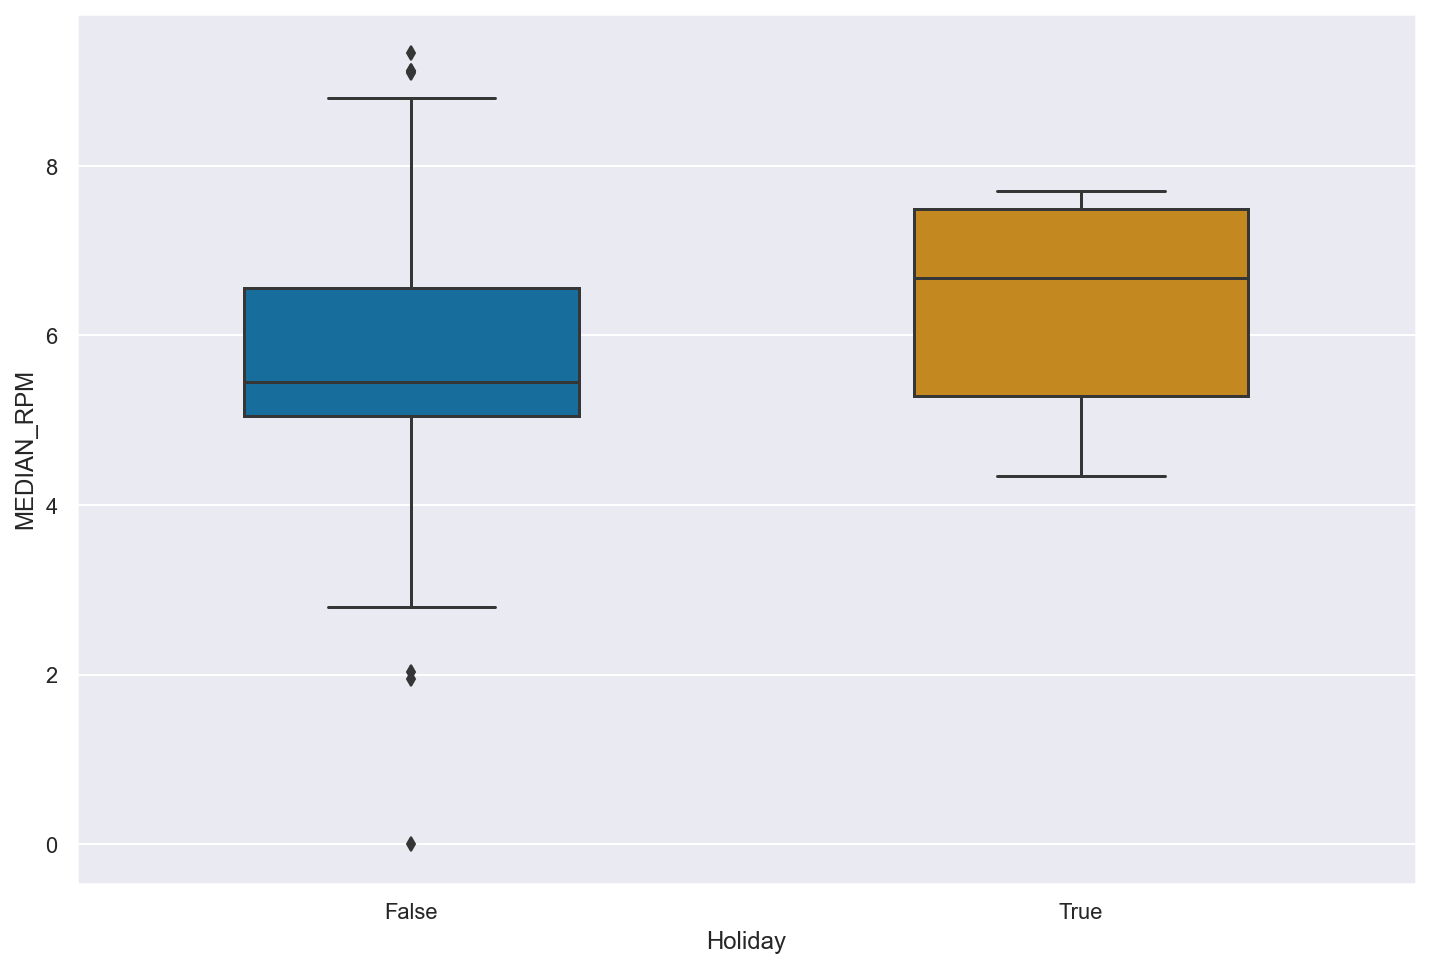

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
bplot=sns.boxplot(y='MEDIAN_RPM', x='Holiday', data=lane, palette="colorblind",width=0.5)

* Rates get higher on holidays with an average around $7 

# DAT Analysis

In [ ]:

%%read_sql dat 
select 
    yrmo
    , avg_linehaul_rate
from 
    "DAT_DATA_SHARE"."DAT"."RV_HIST_J_B_30_KMA_AX_MON_0001423441"
where 
    rate_type = 'Spot'
and 
    omast_kma='CA_ONT'
and 
    dmast_kma='AZ_PHO'
and 
    equipment_category='R'
    order by yrmo

Query started at 04:22:07 PM PDT; Query executed in 0.13 m

In [ ]:
dat

,yrmo,avg_linehaul_rate
0,202110,5.11
1,202111,5.35
2,202112,5.34
3,202201,5.16
4,202202,4.44
5,202203,3.93
6,202204,3.85
7,202205,3.93
8,202206,3.85


In [ ]:
dat['yrmo'] = pd.to_datetime(dat.yrmo, format='%Y%m')
dat['yrmo'] = dat['yrmo'].dt.to_period('M')

In [ ]:
dat_index=dat.set_index('yrmo')

In [ ]:
dat_index

,avg_linehaul_rate
yrmo,
2021-10,5.11
2021-11,5.35
2021-12,5.34
2022-01,5.16
2022-02,4.44
2022-03,3.93
2022-04,3.85
2022-05,3.93
2022-06,3.85


In [ ]:
lane['yearmonth']=lane['index'].dt.to_period('M')

In [ ]:
lane

,index,MEDIAN_RPM,was imputed,weekday,month,Holiday,yearmonth
0,2021-01-04,5.113269,NaN,0,1,False,2021-01
1,2021-01-05,1.942771,NaN,1,1,False,2021-01
2,2021-01-07,5.031447,NaN,3,1,False,2021-01
3,2021-01-13,4.656571,NaN,2,1,False,2021-01
4,2021-01-14,4.407115,NaN,3,1,False,2021-01
...,...,...,...,...,...,...,...
344,2022-05-23,5.105105,NaN,0,5,False,2022-05
345,2022-05-24,5.092553,NaN,1,5,False,2022-05
346,2022-05-25,5.105105,NaN,2,5,False,2022-05
347,2022-05-26,5.105105,NaN,3,5,False,2022-05


In [ ]:
lane=lane.groupby('yearmonth').agg(avg_rpm=('MEDIAN_RPM','mean'))

In [ ]:
lane

,avg_rpm
yearmonth,
2021-01,4.085347
2021-02,4.130803
2021-03,4.837295
2021-04,5.250293
2021-05,6.366278
2021-06,5.930182
2021-07,5.890992
2021-08,5.777175
2021-09,6.126761


## DAT and Payable Correlation

In [ ]:
dat_correlate= pd.concat([dat_index, lane],axis=1)
dat_correlate.head()

,avg_linehaul_rate,avg_rpm
2021-10,5.11,6.876723
2021-11,5.35,6.968505
2021-12,5.34,6.315620
2022-01,5.16,6.123865
2022-02,4.44,5.597729


Pandas computed Pearson r: 0.93
Scipy computed Pearson r: 0.93 and p-value: 0.000805


[Text(0.5, 0, 'Frame'),
 Text(0, 0.5, 'Rates'),
 Text(0.5, 1.0, 'Overall Pearson r = 0.93'),
 (0.0, 10.0)]

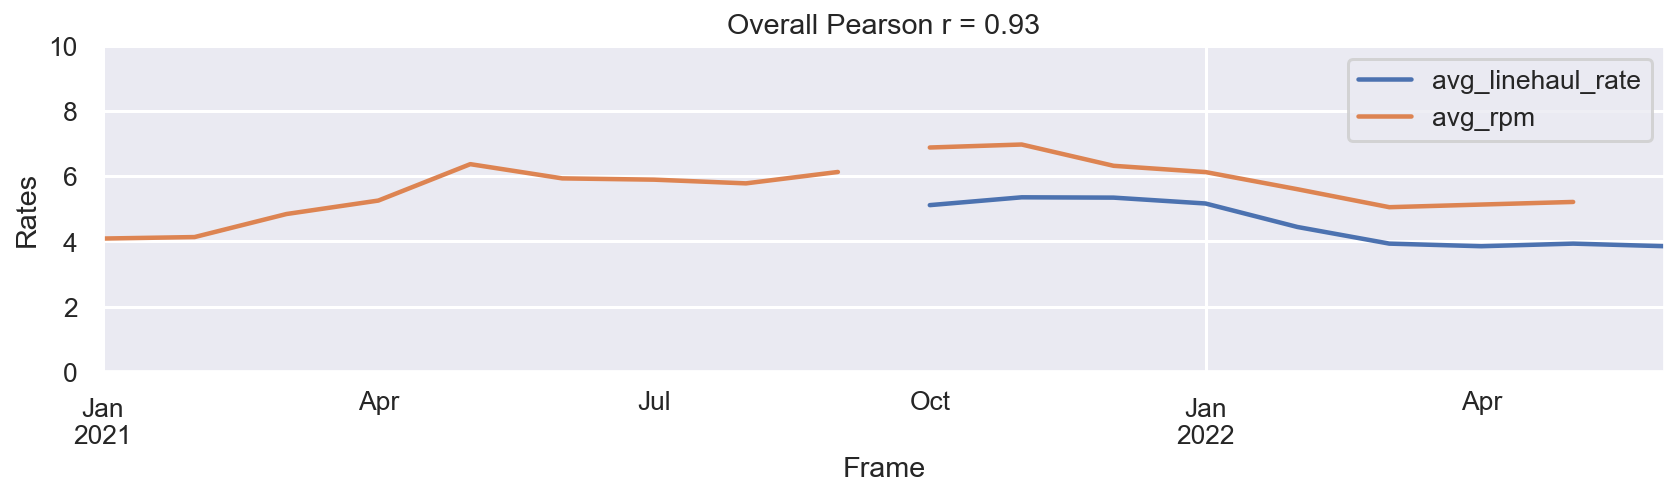

In [ ]:
#pearson corr

%matplotlib inline

import scipy.stats as stats
sns.set_context('talk',font_scale=.8)


overall_pearson_r = dat_correlate.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r:.3g}")

r, p = stats.pearsonr(dat_correlate.dropna()['avg_linehaul_rate'], dat_correlate.dropna()['avg_rpm'])
print(f"Scipy computed Pearson r: {r:.3g} and p-value: {p:.3g}")

f,ax=plt.subplots(figsize=(14,3))
dat_correlate.plot(ax=ax)

ax.set(xlabel='Frame',ylabel='Rates',title=f"Overall Pearson r = {overall_pearson_r:.2g}",ylim=(0,10))

* The pearson value indicates high positive correlation of 0.93 between DAT contract rates and median Payable spot rates for Ontario-Phoenix. The only limitation is the # of observations available for this analysis (n=5).

# Conclusions

## Decisions made

1. Filtering out Ont-Phoenix lane out of the Pacific-Mountain rates to see if the correlation is actually present between all remaining lanes and Ont-Phoenix rates.
2. Looking at values without imputations since they might be non-representative of the data we have and imputing could skew the data correlations.

## Key findings 
 1. Positive correlation of 0.15 between raw values of Ont-Phonenix and Pac-Mountain time-series.
 2. Very strong positive correlation of 0.67 between 7-day averages of Ont-Phoenix and Pac-Mountain time-series.
 3. Specific weekdays, months, holidays, division to division averages may be used as predictors for the future forecasting model.
 4. High positive correlation between DAT contract rates and Payable Spot rates for Ont-Phoenix.
## Next steps
1. Try different values for multipliers.
2. Analyze the outliers
3. Look at other lanes

# Appendix

## Watermark 
For full reproducibility of results, use exact data extraction as defined at top of notebook and ensure that the environment is exactly as follows: 

In [ ]:
# ! pip install watermark
%load_ext watermark
%watermark -v -m --iversions -g

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

Compiler    : Clang 12.0.1 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Git hash: 

statsmodels : 0.13.2
matplotlib  : 3.5.2
seaborn     : 0.11.2
sys         : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:43:32) [Clang 12.0.1 ]
numpy       : 1.22.4
folium      : 0.12.1.post1
pivottablejs: 0.9.0
yaml        : 6.0
json        : 2.0.9
scipy       : 1.8.1
missingno   : 0.4.2
pandas      : 1.4.2
pymysql     : 1.0.2
re          : 2.2.1
sqlalchemy  : 1.4.36



fatal: not a git repository (or any of the parent directories): .git


<center>© <a href="http://lineagelogistics.com">2020 Lineage Logistics</a></center>